<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/tpnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TP réseau de neurones

la liste des paquets nécessaires au programme

In [0]:
from __future__ import print_function
import os
import sys

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd
import torch.autograd.variable

from matplotlib import pyplot as plt

définition de la fonction objectif : veuillez remarquer que cette fonction est calculable par une réseau de neurones

In [2]:
from matplotlib import animation

gridsize = 50

class GroundTruth(nn.Module):
    def __init__(self):
        super(GroundTruth, self).__init__()
        self.fc1 = nn.Linear(2, 4, bias=True)
        self.fc2 = nn.Linear(4, 1, bias=True)
        self.fc3 = nn.Linear(1, 2, bias=True)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forwardnp(self,x):
        variablex = torch.autograd.Variable(torch.Tensor(x.astype(float)))
        variableoutput = self.forward(variablex)
        return variableoutput.cpu().data.numpy()

groundtruth = GroundTruth()
groundtruth.fc1.weight.data[0][0] = -1
groundtruth.fc1.weight.data[0][1] = 0
groundtruth.fc1.bias.data[0] = 10
groundtruth.fc1.weight.data[1][0] = 1
groundtruth.fc1.weight.data[1][1] = 0
groundtruth.fc1.bias.data[1] = -30
groundtruth.fc1.weight.data[2][0] = 0
groundtruth.fc1.weight.data[2][1] = -1
groundtruth.fc1.bias.data[2] = 10
groundtruth.fc1.weight.data[3][0] = 0
groundtruth.fc1.weight.data[3][1] = 1
groundtruth.fc1.bias.data[3] = -30

groundtruth.fc2.bias.data[0] = 3
groundtruth.fc2.weight.data[0][0] = -0.5
groundtruth.fc2.weight.data[0][1] = -0.5
groundtruth.fc2.weight.data[0][2] = -0.5
groundtruth.fc2.weight.data[0][3] = -0.5

groundtruth.fc3.bias.data[0] = -0.5
groundtruth.fc3.weight.data[0][0] = 1
groundtruth.fc3.weight.data[1] = -groundtruth.fc3.weight.data[0]
groundtruth.fc3.bias.data[1] = -groundtruth.fc3.bias.data[0]
groundtruth.eval()





GroundTruth(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=2, bias=True)
)

malheureusement de cette fonction on ne connait qu'un certain nombre d'échantillons

In [0]:
samples = np.random.randint(0,50, size=(50,2))

et, à partir de ces échantillons seulement, on veut estimer la fonction (ce qui est impossible dans l'absolue mais qui peut marcher en pratique vue que les fonctions qu'on cherche à estimer son *régulière*).
Pour cela on définit un réseau :

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 30, bias=True)
        self.fc2 = nn.Linear(30, 30, bias=True)
        self.fc2bis = nn.Linear(30, 30, bias=True)
        self.fc3 = nn.Linear(30, 2, bias=True)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x/30))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc2bis(x))
        x = self.fc3(x)
        return x

    def forwardnp(self,x):
        variablex = torch.autograd.Variable(torch.Tensor(x.astype(float)))
        variableoutput = self.forward(variablex)
        return variableoutput.cpu().data.numpy()

model = Net()
model.train()


Net(
  (fc1): Linear(in_features=2, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc2bis): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
)

et on va apprendre sur les échantillons

ici juste quelques fonctions d'affichage 

In [0]:
def visualizemodel(model,visufond,visusample):
    grid = np.zeros((gridsize,gridsize,3),dtype=int)
    grid[:]=255

    batch = np.zeros((gridsize*gridsize,2),dtype=int)
    for row in range(gridsize):
        for col in range(gridsize):
            batch[row*gridsize+col][0]=row
            batch[row*gridsize+col][1]=col

    prob = model.forwardnp(batch)
    pred = np.argmax(prob,axis=1)

    if visufond:
        grid[:,:,0]=175
        for row in range(gridsize):
            for col in range(gridsize):
                if pred[row*gridsize+col]==1:
                    grid[row][col][1] = 175
                else:
                    grid[row][col][2] = 175

    if visusample:
        for row,col in samples:
            grid[row][col][0]=0
            if pred[row*gridsize+col]==1:
                grid[row][col][1] = 0
            else:
                grid[row][col][2] = 0

    return np.uint8(grid),pred

def visualizeALL():
    gt,gtpred = visualizemodel(groundtruth,True,False)
    justsamples,_ = visualizemodel(groundtruth,False,True)
    model.eval()
    modelout,pred = visualizemodel(model,True,True)
    model.train()
    
    samplemask = np.zeros(gridsize*gridsize,dtype=int)
    for row,col in samples:
        samplemask[row*gridsize+col] = 1
    realerror = np.sum(np.absolute(gtpred-pred))
    observederror = np.sum(np.absolute(gtpred-pred)*samplemask)
    
    return np.concatenate((gt,justsamples,modelout), axis=1),realerror,observederror
  

les paramètres de l'apprentissage

In [0]:
lr = 0.1
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
losslayer = nn.CrossEntropyLoss()
nbepoch = 200

l'apprentissage

real error= 901 	observed error on samples= 22 	optimisation loss= 0.6847686
real error= 901 	observed error on samples= 22 	optimisation loss= 0.6828098
real error= 901 	observed error on samples= 22 	optimisation loss= 0.6802553
real error= 901 	observed error on samples= 22 	optimisation loss= 0.6777603
real error= 901 	observed error on samples= 22 	optimisation loss= 0.67554224
real error= 901 	observed error on samples= 22 	optimisation loss= 0.6736194
real error= 901 	observed error on samples= 22 	optimisation loss= 0.67194176
real error= 901 	observed error on samples= 22 	optimisation loss= 0.67041963
real error= 901 	observed error on samples= 22 	optimisation loss= 0.66895974
real error= 901 	observed error on samples= 22 	optimisation loss= 0.6675369
real error= 901 	observed error on samples= 22 	optimisation loss= 0.666126
real error= 901 	observed error on samples= 22 	optimisation loss= 0.6646672
real error= 901 	observed error on samples= 22 	optimisation loss= 0.6631

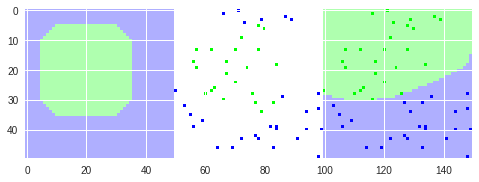

KeyboardInterrupt: ignored

In [7]:
from IPython.display import clear_output # command to clear the figures
from time import sleep

allprints = []
for epoch in range(nbepoch):
    batch = torch.autograd.Variable(torch.Tensor(samples.astype(float)).float())
    target = torch.autograd.Variable(torch.from_numpy(np.argmax(groundtruth.forwardnp(samples),axis=1)).long())

    optimizer.zero_grad()
    output = model(batch)

    loss = losslayer(output, target)
    loss.backward()
    optimizer.step()
    
    
    grid,realerror,observederror = visualizeALL()
    allprints.append(("real error=",realerror,"\tobserved error on samples=", observederror, "\toptimisation loss=", loss.cpu().data.numpy()))
    
    if epoch%5==0:
        clear_output()
        for a,b,c,d,e,f in allprints:
            print(a,b,c,d,e,f)
        plt.imshow(grid)
        plt.show()